In [1]:
# import our usual things
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets
import bqplot
import numpy as np
import datetime as dt # we'll use this to format our dates all fancy like

In [2]:
# read data, parse date and handle null values
building = pd.read_csv('../dataset/IL_Building_Inventory.csv',           
                       na_values = {'Square Footage': 0,
                       'Year Acquired': 0,
                       'Year Constructed': 0},
                      parse_dates = ["Year Acquired", "Year Constructed"]) 

In [3]:
# create agency id to deal with catagorical data
agency_dict = {}
for ind, i in enumerate(building['Agency Name'].unique()):
    agency_dict[i] = ind
building['aid'] = list(map(lambda a:agency_dict[a], building['Agency Name']))

In [4]:
# drop any null values
building = building.dropna(axis="rows", how="any")

In [5]:
# edit congress id to start with 0 (easier to match later)
building['cid'] = building['Congress Dist']-1

In [6]:
building.columns

Index(['Agency Name', 'Location Name', 'Address', 'City', 'Zip code', 'County',
       'Congress Dist', 'Congressional Full Name', 'Rep Dist', 'Rep Full Name',
       'Senate Dist', 'Senator Full Name', 'Bldg Status', 'Year Acquired',
       'Year Constructed', 'Square Footage', 'Total Floors',
       'Floors Above Grade', 'Floors Below Grade', 'Usage Description',
       'Usage Description 2', 'Usage Description 3', 'aid', 'cid'],
      dtype='object')

In [7]:
len(building['cid'].unique()),len(building['aid'].unique())

(18, 35)

In [8]:
sorted(building['Congress Dist'].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [9]:
sorted(building['cid'].unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

In [10]:
building.iloc[1,]

Agency Name                                Department of Natural Resources
Location Name              Anderson Lake Conservation Area - Fulton County
Address                                                 Anderson Lake C.a.
City                                                               Astoria
Zip code                                                             61501
County                                                              Fulton
Congress Dist                                                           17
Congressional Full Name                                       Cheri Bustos
Rep Dist                                                                93
Rep Full Name                                            Hammond Norine K.
Senate Dist                                                             47
Senator Full Name                                                Jil Tracy
Bldg Status                                                         In Use
Year Acquired            

In [11]:
import matplotlib.colors as mpl_colors
# create his2d arrays to draw heap plot
hist2d, con_edges, ag_edges = np.histogram2d(building['cid'], 
                                               building['aid'], 
                                               weights=building['Square Footage'],
                                            bins = [18,35])

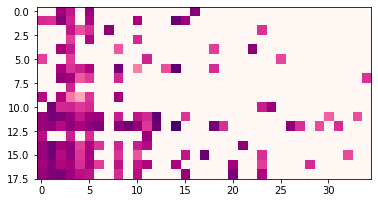

In [12]:
plt.imshow(hist2d, cmap='RdPu', norm = mpl_colors.SymLogNorm(10))

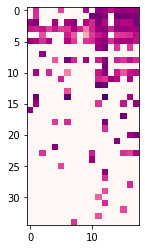

In [13]:
plt.imshow(hist2d.T, cmap='RdPu', norm = mpl_colors.SymLogNorm(10))

In [14]:
hist2d.shape, con_edges.shape, ag_edges.shape

((18, 35), (19,), (36,))

In [15]:
# use log scale to look better
hist2d[hist2d <= 0] = np.nan # set zeros to NaNs
hist2d = np.log10(hist2d)

In [16]:
con_center = sorted(building['Congress Dist'].unique())
aid_center = sorted(building['aid'].unique())

In [17]:
len(con_center),len(aid_center)

(18, 35)

In [18]:

def get_data_value(change):
    if len(change['owner'].selected) == 1: #only 1 selected
        i,j = change['owner'].selected[0]
        v = hist2d[i,j] # grab data value
        mySelectedLabel.value = 'Total duration in log(sec) = ' + str(v) + ' '+str(i) +' '+str(j) # set our label

# (1) add scales - colors, x & y
col_sc = bqplot.ColorScale(scheme="RdPu", 
                           min=np.nanmin(hist2d), 
                           max=np.nanmax(hist2d))

x_sc = bqplot.LinearScale()
y_sc = bqplot.LinearScale()

c_ax = bqplot.ColorAxis(scale = col_sc, 
                        orientation = 'vertical', 
                        side = 'right')

# (2) create axis - for colors, x & y

x_ax = bqplot.Axis(scale = x_sc, label='Agency Name')
y_ax = bqplot.Axis(scale = y_sc, 
                   orientation = 'vertical', 
                   label = 'Congress Dist')
# (3) Marks
heat_map = bqplot.GridHeatMap(color = hist2d,
                              row = con_center, 
                              column = aid_center,
                              scales = {'color': col_sc,
                                        'row': y_sc,
                                        'column': x_sc},
                              interactions = {'click': 'select'},
                              anchor_style = {'fill':'blue'}, 
                              selected_style = {'opacity': 1.0},
                              unselected_style = {'opacity': 1.0})

# (4) interactivity - none yet
mySelectedLabel = ipywidgets.Label()

heat_map.observe(get_data_value, 'selected')


# (5) put it all together in a figure
fig = bqplot.Figure(marks = [heat_map], axes = [c_ax, y_ax, x_ax])
myDashboard = ipywidgets.VBox([mySelectedLabel,fig])
myDashboard

In [19]:
# (1) add scales - colors, x & y, use different color scheme
col_sc = bqplot.ColorScale(scheme="PuOr",
                           min=np.nanmin(hist2d),
                           max=np.nanmax(hist2d))

x_sc = bqplot.LinearScale()
y_sc = bqplot.LinearScale()

c_ax = bqplot.ColorAxis(scale=col_sc,
                        orientation='vertical',
                        side='right')


# (2) create axis - for colors, x & y
x_ax = bqplot.Axis(scale=x_sc, label='Agency Name')
y_ax = bqplot.Axis(scale=y_sc,
                   orientation='vertical',
                   label='Congress Dist')


# (3) Marks in left side
heat_map = bqplot.GridHeatMap(color=hist2d,
                              row=con_center,
                              column=aid_center,
                              scales={'color': col_sc,
                                      'row': y_sc,
                                      'column': x_sc},
                              interactions={'click': 'select'},
                              anchor_style={'fill': 'blue'},
                              selected_style={'opacity': 1.0},
                              unselected_style={'opacity': 1.0})

# (4) interactivity
i, j = 17, 0  # picking an x/y bin -- this is one I know has a lot of data!

ca_mask = (building['aid'] == j) & (
    building['Congress Dist'] == i)  # create init mask

# note: for dates on x-axis and customize date range based on mask
x_scl = bqplot.DateScale(min=min(building['Year Constructed'][ca_mask]), max=max(
    building['Year Constructed'][ca_mask]))
y_scl = bqplot.LogScale()  # log scale to look better

ax_xcl = bqplot.Axis(label='Date', scale=x_scl)
ax_ycl = bqplot.Axis(label='Square Footage', scale=y_scl,
                     orientation='vertical', side='left')

# rigiht side line plot x and y, use group by index and values
line_year = building[:][ca_mask].groupby('Year Constructed')[
    'Square Footage'].sum().index
sum_year = building[:][ca_mask].groupby('Year Constructed')[
    'Square Footage'].sum()

# use small mark to show line plot to deal with few data situation
duration_line = bqplot.Lines(x=line_year,
                             y=sum_year,
                             scales={'x': x_scl, 'y': y_scl}, marker='circle', marker_size=32)

# link between left and right
def get_data_value(change):
    if len(change['owner'].selected) == 1:  # only 1 selected
        i, j = change['owner'].selected[0]
        v = hist2d[i, j]  # grab data value
        ca_mask = (building['aid'] == j) & (building['cid'] == i)
        # make sure point exist so no histogram errors!
        if len(building['Square Footage'][ca_mask]) > 0:
            line_year = building[:][ca_mask].groupby('Year Constructed')[
                'Square Footage'].sum().index
            sum_year = building[:][ca_mask].groupby('Year Constructed')[
                'Square Footage'].sum()
            x_scl = bqplot.DateScale(min=min(building['Year Constructed'][ca_mask]), max=max(
                building['Year Constructed'][ca_mask]))  # note: for dates on x-axis
            y_scl = bqplot.LogScale()

            # update data and date scale
            duration_line.x = line_year
            duration_line.y = sum_year
            ax_xcl.scale = x_scl
        else:
            # use empty data in black cells
            duration_line.x = []
            duration_line.y = []
        # simple strings to debug here
        mySelectedLabel.value = 'Total duration in log(sec) = ' + str(v) + ' '+str(
            i) + ' '+str(j)+' '+str(len(building['Year Constructed'][ca_mask]))  # set our label


mySelectedLabel = ipywidgets.Label()

heat_map.observe(get_data_value, 'selected')


# (5) create figures
fig_heatmap = bqplot.Figure(marks=[heat_map], axes=[c_ax, y_ax, x_ax])
fig_dur = bqplot.Figure(marks=[duration_line], axes=[ax_xcl, ax_ycl])

# since we know from last time we wanna make our figs a bit bigger:
fig_heatmap.layout.min_width = '500px'
fig_dur.layout.min_width = '500px'

myDashboard = ipywidgets.VBox(
    [mySelectedLabel, ipywidgets.HBox([fig_heatmap, fig_dur])])
myDashboard

In [20]:
hist2d[12][6],np.log10(building['Square Footage'][(building['cid']==12) & (building['aid']==6)].sum())

(6.301210624600238, 6.301210624600238)

## Several considerations

Can you keep the x and y ranges static on the line plot?


I think technically we can do that, but in this dataset, the date values differ a lot, so I prefer to optimize range based on the data after masking so I manually update it above.

Can you change the style?

Yes, but as the Github issue page, the bqplot does not support all the ColorBrewer schmes. Only below can fully support:
[
"Paired", "Set3", "Pastel1", "Set1",
"Greys", "Greens", "Reds", "Purples", "Oranges", "Blues",
"YlOrRd", "YlOrBr", "YlGnBu", "YlGn", "RdPu",
"PuRd", "PuBuGn", "PuBu", "OrRd", "GnBu", "BuPu",
"BuGn", "BrBG", "PiYG", "PRGn", "PuOr", "RdBu", "RdGy",
"RdYlBu", "RdYlGn", "Spectral"
]